# **Environment Setup & Data Read**

Here, we import Pandas for data processing. We check to see the memory usage of the dataframe read in. Given that the dataframe can comfortable fit within the memory of the machine we are using, we can confidently continue with Pandas. Had this not been the case, we would have proceeded with Pyspark for data processing. 

In [70]:
# Jupyter output
import warnings
warnings.filterwarnings('ignore')

# Import general libraries
import pandas as pd
pd.set_option('display.max_columns', None)
from scipy.stats import randint, uniform
from tqdm import tqdm 

# Import libraries for model
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from xgboost import XGBClassifier

# Importing custom modules
from importlib import reload
reload_condition = True
import utils as ut

if reload_condition:
    reload(ut)

In [6]:
# Read in data
strike_df = pd.read_parquet('strikedata.parquet')

# Check memory usage
memory_gb = strike_df.memory_usage(deep=True).sum() / 1000000000
print('Memory usage of dataframe is {:.2f} GB'.format(memory_gb))

Memory usage of dataframe is 0.29 GB


In [7]:
# Quick view of data structure
strike_df.head(10)

,PITCH_KEY,GAMEPK,GAME_DATE,INNING_HALF,Year,League_ID,PITCHER_ID,PITCHER_SIDE,BATTER_ID,BATTER_SIDE,BATTER_HEIGHT_IN,OUTS,BALLS,STRIKES,PITCH_RELEASE_VELO,TRACK_RELEASE_SIDE,TRACK_RELEASE_HEIGHT,TRACK_RELEASE_ANGLE_VERT,TRACK_RELEASE_ANGLE_HORIZ,TRACK_RELEASE_EXTENSION,TRACK_APPR_ACCEL_X,TRACK_APPR_ACCEL_Y,TRACK_APPR_ACCEL_Z,TRACK_PLATE_X,TRACK_PLATE_Z,pitch_outcome_id,pitch_outcome_name
0,95136416,529416,2018-03-29,1,2018,NL,595465,R,467793,L,71.0,1,2,2,94.283073,1.836442,5.360555,0.161273,-1.563570,6.016098,-9.185337,34.856476,-12.551595,1.061653,4.490934,2,Ball
1,95100329,529416,2018-03-29,1,2018,NL,595465,R,467793,L,71.0,1,0,1,90.900421,2.021586,5.178264,-0.484359,-3.559973,5.933589,4.973417,26.203642,-23.254955,-1.857962,2.691414,2,Ball
2,95142428,529416,2018-03-29,1,2018,NL,595465,R,467793,L,71.0,1,1,2,93.970642,1.821961,5.295847,0.196058,-1.273360,5.946202,-10.126297,30.844500,-13.260889,1.410896,4.404634,2,Ball
3,95221378,529416,2018-03-29,1,2018,NL,595465,R,467793,L,71.0,1,0,0,94.036186,1.948989,5.279838,-1.056873,-2.766224,6.102707,-6.981641,31.926218,-14.742636,-0.168085,3.052946,8,StrikeCalled
4,95026181,529416,2018-03-29,1,2018,NL,527054,R,595284,L,73.0,2,0,0,89.912376,1.961421,5.048395,-0.930966,-1.640306,5.997355,-6.523272,27.654985,-16.904480,0.950111,2.644435,8,StrikeCalled
5,95026291,529416,2018-03-29,1,2018,NL,527054,R,595284,L,73.0,2,1,2,78.949875,1.772668,4.773604,-1.544461,-4.047848,5.718820,2.997156,21.608366,-30.319881,-2.534204,-0.290358,2,Ball
6,95103728,529416,2018-03-29,1,2018,NL,527054,R,595284,L,73.0,2,0,2,89.338638,2.067608,5.037737,0.724991,-2.644353,6.145785,-8.351307,27.049145,-17.334429,0.257906,4.188417,2,Ball
7,95195931,529416,2018-03-29,2,2018,NL,605400,R,527054,R,74.0,0,0,0,90.342262,2.047164,4.903065,-1.512953,-3.687308,6.352959,-13.517827,28.186758,-17.492699,-0.331193,1.917746,8,StrikeCalled
8,95122168,529416,2018-03-29,2,2018,NL,605400,R,527054,R,74.0,0,0,1,75.881744,2.138564,5.090311,1.571812,-0.327449,6.097074,12.443213,22.932608,-40.095657,0.249492,1.565629,8,StrikeCalled
9,95242769,529407,2018-03-29,2,2018,NL,518553,R,516770,R,74.0,1,1,1,77.345551,3.512944,4.336934,1.872215,-0.826135,6.885411,14.352231,26.304304,-34.224911,1.005561,2.069280,8,StrikeCalled


# **Exploratory Data Analysis**

## Data Cleaning & Initial Exploration

### Missing Values

In [8]:
# Missing Value Checks
strike_df[(strike_df.isnull().any(axis=1)) | (strike_df.isna().any(axis=1)) | (strike_df == '').any(axis=1)]

,PITCH_KEY,GAMEPK,GAME_DATE,INNING_HALF,Year,League_ID,PITCHER_ID,PITCHER_SIDE,BATTER_ID,BATTER_SIDE,BATTER_HEIGHT_IN,OUTS,BALLS,STRIKES,PITCH_RELEASE_VELO,TRACK_RELEASE_SIDE,TRACK_RELEASE_HEIGHT,TRACK_RELEASE_ANGLE_VERT,TRACK_RELEASE_ANGLE_HORIZ,TRACK_RELEASE_EXTENSION,TRACK_APPR_ACCEL_X,TRACK_APPR_ACCEL_Y,TRACK_APPR_ACCEL_Z,TRACK_PLATE_X,TRACK_PLATE_Z,pitch_outcome_id,pitch_outcome_name


### Data Ranges Checks - Categorical

In [9]:
cat_variables = ['PITCH_KEY', 'GAMEPK', 'GAME_DATE', 'INNING_HALF', 'Year', 'League_ID',
                 'PITCHER_ID', 'PITCHER_SIDE', 'BATTER_ID', 'BATTER_SIDE',
                 'OUTS', 'BALLS', 'STRIKES', 'pitch_outcome_id', 'pitch_outcome_name']

variable_range_data = {}
for variable in cat_variables:
    variable_range_data[variable] = strike_df[variable].unique()

In [10]:
# Confirm that each pitch has a unique pitch ID
print('Each Row has a Unique Pitch ID: ', len(variable_range_data['PITCH_KEY']) == len(strike_df))

# Confirm that inning half is either 1 or 2
print('Inning Half is either 1 or 2: ', len(variable_range_data['INNING_HALF']) == 2)

# Confirm that pitcher side and batter side are R or L
print('Pitcher Side is either R or L: ', len(variable_range_data['PITCHER_SIDE']) == 2)
print('Batter Side is either R or L: ', len(variable_range_data['BATTER_SIDE']) == 2)

# Confirm that outs is between 0 and 2
print('Outs is between 0 and 2: ', len(variable_range_data['OUTS']) == 3)

# Confirm that balls is between 0 and 3 and strikes is between 0 and 2
print('Balls is between 0 and 3: ', len(variable_range_data['BALLS']) == 4)
print('Strikes is between 0 and 2: ', len(variable_range_data['STRIKES']) == 3)

# Count number of unique games 
print('')
print('Number of Unique Game Primary Keys: ', len(variable_range_data['GAMEPK']))
print('Number of Unique Pitcher IDs: ', len(variable_range_data['PITCHER_ID']))
print('Number of Unique Batter IDs: ', len(variable_range_data['BATTER_ID']))

Each Row has a Unique Pitch ID:  True
Inning Half is either 1 or 2:  True
Pitcher Side is either R or L:  True
Batter Side is either R or L:  True
Outs is between 0 and 2:  True
Balls is between 0 and 3:  True
Strikes is between 0 and 2:  True

Number of Unique Game Primary Keys:  4817
Number of Unique Pitcher IDs:  1033
Number of Unique Batter IDs:  1213


### Variable Value Breakdown - Categorical

In [11]:
cat_variables = ['PITCH_KEY', 'GAMEPK', 'GAME_DATE', 'INNING_HALF', 'Year', 'League_ID',
                 'PITCHER_ID', 'PITCHER_SIDE', 'BATTER_ID', 'BATTER_SIDE',
                 'OUTS', 'BALLS', 'STRIKES', 'pitch_outcome_id', 'pitch_outcome_name']

# Get breakdown of variables
print('Distribution of Year Variable')
print(strike_df['Year'].value_counts())
print('')

print('Distribution of League_ID Variable')
print(strike_df['League_ID'].value_counts())
print('')

print('Distribution of PITCHER_SIDE Variable')
print(strike_df['PITCHER_SIDE'].value_counts())
print('')

print('Distribution of BATTER_SIDE Variable')
print(strike_df['BATTER_SIDE'].value_counts())
print('')

Distribution of Year Variable
Year
2019    378191
2018    277763
Name: count, dtype: int64

Distribution of League_ID Variable
League_ID
AL    330341
NL    325613
Name: count, dtype: int64

Distribution of PITCHER_SIDE Variable
PITCHER_SIDE
R    468553
L    187401
Name: count, dtype: int64

Distribution of BATTER_SIDE Variable
BATTER_SIDE
R    382024
L    273930
Name: count, dtype: int64



### Data Distributions - Continuous

In [12]:
cont_variables = strike_df.columns.difference(cat_variables)

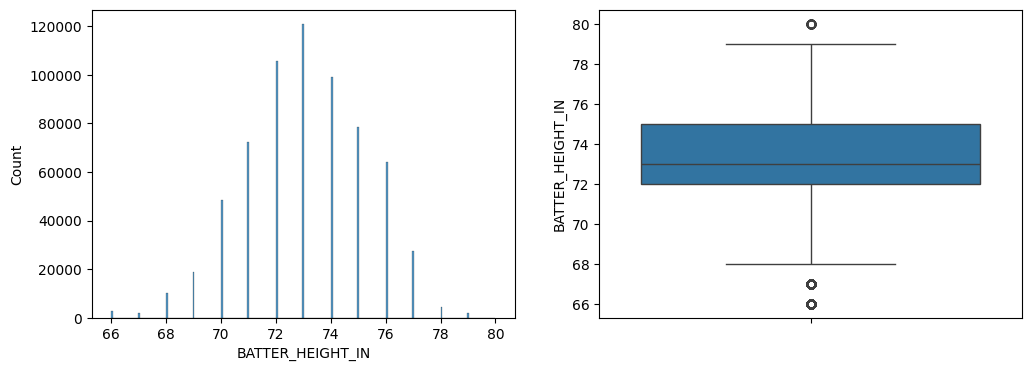

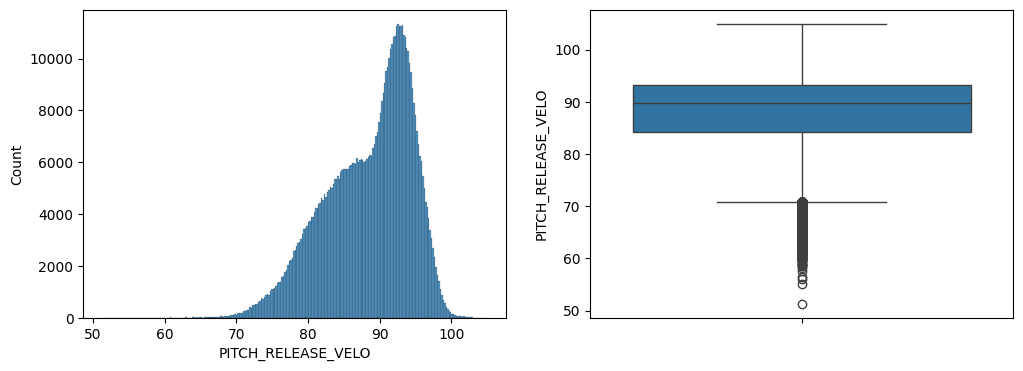

KeyboardInterrupt: 

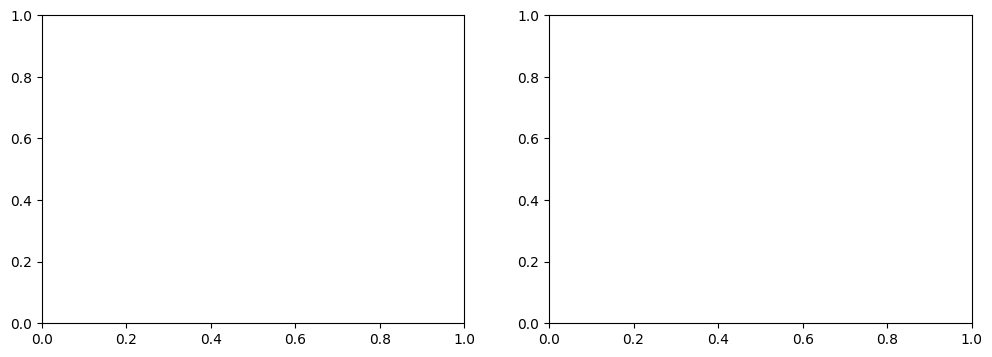

In [13]:
ut.plot_distribution(strike_df['BATTER_HEIGHT_IN'])
ut.plot_distribution(strike_df['PITCH_RELEASE_VELO'])
ut.plot_distribution(strike_df['TRACK_APPR_ACCEL_X'])
ut.plot_distribution(strike_df['TRACK_APPR_ACCEL_Y'])
ut.plot_distribution(strike_df['TRACK_APPR_ACCEL_Z'])
ut.plot_distribution(strike_df['TRACK_PLATE_X'])
ut.plot_distribution(strike_df['TRACK_PLATE_Z'])
ut.plot_distribution(strike_df['TRACK_RELEASE_ANGLE_HORIZ'])
ut.plot_distribution(strike_df['TRACK_RELEASE_ANGLE_VERT'])
ut.plot_distribution(strike_df['TRACK_RELEASE_EXTENSION'])
ut.plot_distribution(strike_df['TRACK_RELEASE_HEIGHT'])
ut.plot_distribution(strike_df['TRACK_RELEASE_SIDE'])

## Variable Redefinition

### Categorical Variables

In [14]:
# Extract month from game date
strike_df['GAME_DATE'] = pd.to_datetime(strike_df['GAME_DATE'])
strike_df['GAME_MONTH'] = strike_df['GAME_DATE'].dt.month

In [15]:
# Concatenate pitcher side and batter side to create batter pitcher side
strike_df['PITCHER_BATTER_SIDE'] = strike_df['PITCHER_SIDE'] + '_' + strike_df['BATTER_SIDE']
strike_df['PITCHER_BATTER_SIDE'].value_counts()

PITCHER_BATTER_SIDE
R_R    247283
R_L    221270
L_R    134741
L_L     52660
Name: count, dtype: int64

In [16]:
# Concatenate balls and strikes to create count
strike_df['COUNT'] = strike_df['BALLS'].astype(str) + '_' + strike_df['STRIKES'].astype(str)
strike_df['COUNT'].value_counts()

COUNT
0_0    223091
0_1     83080
1_0     71250
1_1     58828
1_2     50841
0_2     39831
2_2     36377
2_1     27727
2_0     23750
3_2     17455
3_1     12144
3_0     11580
Name: count, dtype: int64

### Target Variable

In [47]:
target_replace_dict = {2: 0, 8:1}
strike_df['pitch_outcome_id'] = strike_df['pitch_outcome_id'].replace(target_replace_dict)

## Target Variable Exploration

In [17]:
print('Distribution of Pitch Outcome')
print(strike_df['pitch_outcome_name'].value_counts())
print('')
print(strike_df['pitch_outcome_id'].value_counts())

Distribution of Pitch Outcome
pitch_outcome_name
Ball            448790
StrikeCalled    207164
Name: count, dtype: int64

pitch_outcome_id
2    448790
8    207164
Name: count, dtype: int64


In [48]:
# Create a dictionary using pitch outcome name and id columns
pitch_outcome_dict = dict(zip(strike_df['pitch_outcome_name'], strike_df['pitch_outcome_id']))
pitch_outcome_dict

{'Ball': 0, 'StrikeCalled': 1}

### Correlation Analysis - Categorical

In [19]:
cat_variables_slim = ['GAME_MONTH', 'INNING_HALF', 'Year', 'League_ID', 'PITCHER_SIDE', 'BATTER_SIDE', 'OUTS', 'BALLS',
                      'STRIKES', 'COUNT']
 
for cat_var in cat_variables_slim:
    print(cat_var)
    cat_var_dict = ut.get_target_correlation(strike_df, cat_var, 'categorical', target='pitch_outcome_id')
    cat_var_df = pd.DataFrame.from_dict(cat_var_dict, orient='index', columns=['Difference', 'P-Value'])
    cat_var_df['Difference'] = cat_var_df['Difference'] * 100
    print(cat_var_df)
    print('')

GAME_MONTH


    Difference  P-Value
3          0.2    0.650
4          0.5    0.003
7         -0.1    0.501
8         -0.1    0.598
9         -0.3    0.058
6         -0.2    0.336
5          0.2    0.264
10        -1.6    0.565

INNING_HALF
   Difference  P-Value
1         0.5      0.0
2        -0.5      0.0

Year
      Difference  P-Value
2018         0.6      0.0
2019        -0.6      0.0

League_ID
    Difference  P-Value
NL         0.2    0.037
AL        -0.2    0.037

PITCHER_SIDE
   Difference  P-Value
R         0.1    0.427
L        -0.1    0.427

BATTER_SIDE
   Difference  P-Value
L        -1.5      0.0
R         1.5      0.0

OUTS
   Difference  P-Value
1        -0.5      0.0
2        -1.7      0.0
0         2.2      0.0

BALLS
   Difference  P-Value
2        -5.2      0.0
0         6.5      0.0
1        -7.0      0.0
3         6.3      0.0

STRIKES
   Difference  P-Value
2       -25.8      0.0
1       -10.1      0.0
0        25.9      0.0

COUNT
     Difference  P-Value
2_2       -18.8  

In [27]:
for cont_var in cont_variables:
    cont_var_dict = ut.get_target_correlation(strike_df, cont_var, 'continuous', target='pitch_outcome_id')
    cont_var_df = pd.DataFrame.from_dict(cont_var_dict, orient='index', columns=['Difference', 'Diff as Pct of Range', 'P-Value'])
    print(cont_var_df)
    print('')

                  Difference  Diff as Pct of Range  P-Value
BATTER_HEIGHT_IN      -0.055                 -0.39      0.0

                    Difference  Diff as Pct of Range  P-Value
PITCH_RELEASE_VELO       0.263                  0.49      0.0

                    Difference  Diff as Pct of Range  P-Value
TRACK_APPR_ACCEL_X      -0.047                 -0.07    0.095

                    Difference  Diff as Pct of Range  P-Value
TRACK_APPR_ACCEL_Y       0.119                  0.34      0.0

                    Difference  Diff as Pct of Range  P-Value
TRACK_APPR_ACCEL_Z       0.711                  0.85      0.0

               Difference  Diff as Pct of Range  P-Value
TRACK_PLATE_X       0.066                  0.39      0.0

               Difference  Diff as Pct of Range  P-Value
TRACK_PLATE_Z        0.25                  1.62      0.0

                           Difference  Diff as Pct of Range  P-Value
TRACK_RELEASE_ANGLE_HORIZ       0.064                  0.35      0.0

          

# **Modeling**

## Data Preprocessing

In [49]:
strike_df = strike_df.sample(frac=1)

In [50]:
model_variables = ['GAME_MONTH', 'INNING_HALF', 'League_ID', 'PITCHER_SIDE', 'BATTER_SIDE', 'BATTER_HEIGHT_IN',
                   'OUTS', 'BALLS', 'STRIKES', 'PITCH_RELEASE_VELO', 'TRACK_RELEASE_SIDE', 'TRACK_RELEASE_HEIGHT',
                   'TRACK_RELEASE_ANGLE_VERT', 'TRACK_RELEASE_ANGLE_HORIZ', 'TRACK_RELEASE_EXTENSION', 
                   'TRACK_APPR_ACCEL_X', 'TRACK_APPR_ACCEL_Y','TRACK_APPR_ACCEL_Z', 'TRACK_PLATE_X', 'TRACK_PLATE_Z', 
                   'PITCHER_BATTER_SIDE', 'COUNT']

strike_X = strike_df[model_variables]
strike_y = strike_df['pitch_outcome_id']

### One Hot Encoding

In [51]:
game_month_dummies = pd.get_dummies(strike_X['GAME_MONTH'], prefix='GAME_MONTH')
inning_half_dummies = pd.get_dummies(strike_X['INNING_HALF'], prefix='INNING_HALF')
league_id_dummies = pd.get_dummies(strike_X['League_ID'], prefix='League_ID')
pitcher_side_dummies = pd.get_dummies(strike_X['PITCHER_SIDE'], prefix='PITCHER_SIDE')
batter_side_dummies = pd.get_dummies(strike_X['BATTER_SIDE'], prefix='BATTER_SIDE')
outs_dummies = pd.get_dummies(strike_X['OUTS'], prefix='OUTS')
balls_dummies = pd.get_dummies(strike_X['BALLS'], prefix='BALLS')
strikes_dummies = pd.get_dummies(strike_X['STRIKES'], prefix='STRIKES')
pitcher_batter_side_dummies = pd.get_dummies(strike_X['PITCHER_BATTER_SIDE'], prefix='PITCHER_BATTER_SIDE')
count_dummies = pd.get_dummies(strike_X['COUNT'], prefix='COUNT')

strike_X = pd.concat([strike_X, game_month_dummies, inning_half_dummies, league_id_dummies, pitcher_side_dummies,
                        batter_side_dummies, outs_dummies, balls_dummies, strikes_dummies, pitcher_batter_side_dummies,
                        count_dummies], axis=1)

strike_X = strike_X.drop(['GAME_MONTH', 'INNING_HALF', 'League_ID', 'PITCHER_SIDE', 'BATTER_SIDE', 'OUTS', 'BALLS',
                            'STRIKES', 'PITCHER_BATTER_SIDE', 'COUNT'], axis=1)

strike_X.head(10)

,BATTER_HEIGHT_IN,PITCH_RELEASE_VELO,TRACK_RELEASE_SIDE,TRACK_RELEASE_HEIGHT,TRACK_RELEASE_ANGLE_VERT,TRACK_RELEASE_ANGLE_HORIZ,TRACK_RELEASE_EXTENSION,TRACK_APPR_ACCEL_X,TRACK_APPR_ACCEL_Y,TRACK_APPR_ACCEL_Z,TRACK_PLATE_X,TRACK_PLATE_Z,GAME_MONTH_3,GAME_MONTH_4,GAME_MONTH_5,GAME_MONTH_6,GAME_MONTH_7,GAME_MONTH_8,GAME_MONTH_9,GAME_MONTH_10,INNING_HALF_1,INNING_HALF_2,League_ID_AL,League_ID_NL,PITCHER_SIDE_L,PITCHER_SIDE_R,BATTER_SIDE_L,BATTER_SIDE_R,OUTS_0,OUTS_1,OUTS_2,BALLS_0,BALLS_1,BALLS_2,BALLS_3,STRIKES_0,STRIKES_1,STRIKES_2,PITCHER_BATTER_SIDE_L_L,PITCHER_BATTER_SIDE_L_R,PITCHER_BATTER_SIDE_R_L,PITCHER_BATTER_SIDE_R_R,COUNT_0_0,COUNT_0_1,COUNT_0_2,COUNT_1_0,COUNT_1_1,COUNT_1_2,COUNT_2_0,COUNT_2_1,COUNT_2_2,COUNT_3_0,COUNT_3_1,COUNT_3_2
379752,72.0,74.468842,3.350712,1.743114,4.052488,-0.906463,5.816705,3.361628,18.950428,-31.457493,2.028458,1.573896,False,False,True,False,False,False,False,False,False,True,True,False,False,True,True,False,True,False,False,True,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False
218318,73.0,88.269165,-1.264525,5.944880,-2.285772,3.611060,6.208069,15.427915,23.299990,-25.130754,0.806268,1.465999,False,False,False,False,True,False,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False
264931,72.0,93.067017,0.868505,5.686286,-2.959278,-1.726795,6.880591,-6.216605,28.673513,-13.532025,-0.277186,1.785481,False,True,False,False,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False
394519,75.0,87.134804,2.167071,5.611299,-3.089861,-4.784269,7.567430,-10.110516,25.238060,-19.367565,-1.429640,0.966871,False,False,False,False,True,False,False,False,False,True,False,True,False,True,False,True,True,False,False,True,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False
203729,74.0,94.688522,-1.592880,6.308084,-2.662166,0.801317,5.374986,5.913534,29.810379,-10.982648,-1.292026,2.797171,False,False,False,False,False,False,True,False,False,True,True,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False
591263,76.0,94.868568,2.586320,6.223080,-3.204734,-6.048285,5.936042,-22.959991,30.820698,-21.805450,-1.447234,1.320829,True,False,False,False,False,False,False,False,False,True,True,False,False,True,False,True,True,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False
603873,74.0,94.366402,-2.111621,6.215104,-3.297692,0.946440,5.352582,5.875061,29.494955,-16.973045,-1.669261,1.575568,False,True,False,False,False,False,False,False,True,False,False,True,True,False,False,True,True,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True
363347,75.0,89.971115,1.305467,5.550267,-0.472110,-1.736403,6.651811,-4.000854,32.963577,-14.762798,-0.019853,3.795018,False,False,True,False,False,False,False,False,True,False,True,False,False,True,False,True,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False
267976,73.0,92.102585,3.021348,5.622575,-2.437298,-3.619389,5.964701,-16.060822,27.768080,-19.236652,0.874544,1.625140,False,False,False,False,False,True,False,False,True,False,True,False,False,True,True,False,True,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False
59

## Prototype I: XGBoost

### Train Test Split

In [52]:
X_train, X_test, y_train, y_test = train_test_split(strike_X, strike_y, test_size=0.2)

### Run and Evaluate

In [73]:
param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.2),
    'booster': ['gbtree', 'gblinear', 'dart']
}

model = XGBClassifier(verbosity = 0)

random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=30, 
    scoring='neg_mean_squared_error', 
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

with tqdm(total=30, desc="RandomizedSearchCV Progress") as pbar:
    def tqdm_callback(_, __):
        pbar.update(1)
    random_search.fit(X_train, y_train)

RandomizedSearchCV Progress:   0%|          | 0/30 [00:00<?, ?it/s]

Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [56]:
predictions = random_search.predict(X_test)
accuracy_score(y_test, predictions)

0.9316873870921023

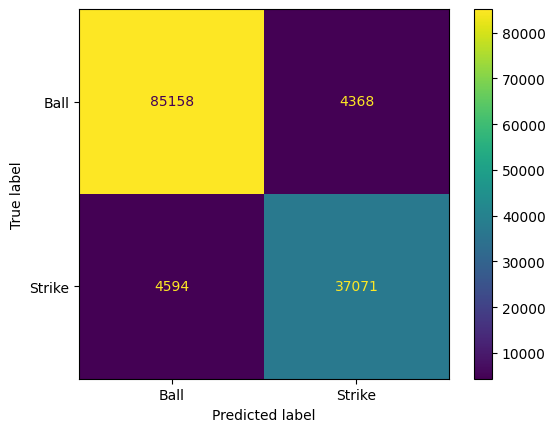

In [61]:
cm = confusion_matrix(predictions, y_test)
ConfusionMatrixDisplay(cm, display_labels=['Ball', 'Strike']).plot()